<a href="https://colab.research.google.com/github/Sudheshna1004/Eye-Gaze-Detection/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Path to your zip file in Google Drive
zip_path = "/content/drive/MyDrive/columbia_gaze_data_set.zip"
extract_path = "/content/columbia_gaze"

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction complete!")


✅ Extraction complete!


In [ ]:
from pathlib import Path

BASE_DIR = Path("/content/columbia_gaze")
IMG_DIR = BASE_DIR / "images"        # Adjust these if needed
MAT_DIR = BASE_DIR / "gaze_data"
OUTPUT_DIR = BASE_DIR / "labeled_data"

ATTENTIVE_DIR = OUTPUT_DIR / "attentive"
DISTRACTED_DIR = OUTPUT_DIR / "distracted"

# Now create folders safely
ATTENTIVE_DIR.mkdir(parents=True, exist_ok=True)
DISTRACTED_DIR.mkdir(parents=True, exist_ok=True)


In [ ]:
!pip install scipy


In [ ]:
import os

for root, dirs, files in os.walk("/content/columbia_gaze"):
    print(f"📂 {root}")
    for file in files[:5]:  # Show just a few files
        print("   -", file)
    print("...")


📂 /content/columbia_gaze
...
📂 /content/columbia_gaze/labeled_data
...
📂 /content/columbia_gaze/labeled_data/distracted
   - 0025_2m_-15P_0V_5H.jpg
   - 0044_2m_-15P_0V_5H.jpg
   - 0003_2m_-30P_-10V_-15H.jpg
   - 0033_2m_15P_-10V_15H.jpg
   - 0042_2m_-30P_-10V_-5H.jpg
...
📂 /content/columbia_gaze/labeled_data/attentive
   - 0039_2m_0P_0V_0H.jpg
   - 0041_2m_0P_0V_-5H.jpg
   - 0024_2m_0P_-10V_5H.jpg
   - 0010_2m_0P_10V_5H.jpg
   - 0021_2m_0P_0V_0H.jpg
...
📂 /content/columbia_gaze/__MACOSX
...
📂 /content/columbia_gaze/__MACOSX/Columbia Gaze Data Set
   - ._.DS_Store
...
📂 /content/columbia_gaze/__MACOSX/Columbia Gaze Data Set/0045
   - ._.DS_Store
...
📂 /content/columbia_gaze/__MACOSX/Columbia Gaze Data Set/0040
   - ._.DS_Store
...
📂 /content/columbia_gaze/__MACOSX/Columbia Gaze Data Set/0041
   - ._.DS_Store
...
📂 /content/columbia_gaze/__MACOSX/Columbia Gaze Data Set/0007
   - ._.DS_Store
...
📂 /content/columbia_gaze/__MACOSX/Columbia Gaze Data Set/0009
   - ._.DS_Store
...
📂 /content

In [ ]:
import shutil
from pathlib import Path
import re

# Base directory
BASE_DIR = Path("/content/columbia_gaze/Columbia Gaze Data Set")

# Output folders
OUTPUT_DIR = Path("/content/columbia_gaze/labeled_data")
ATTENTIVE_DIR = OUTPUT_DIR / "attentive"
DISTRACTED_DIR = OUTPUT_DIR / "distracted"
ATTENTIVE_DIR.mkdir(parents=True, exist_ok=True)
DISTRACTED_DIR.mkdir(parents=True, exist_ok=True)

# Define thresholds for gaze direction
PITCH_THRESHOLD = 10
YAW_THRESHOLD = 10

def extract_angles(filename):
    """
    Extract pitch and yaw from the filename.
    Example: '0001_2m_15P_10V_-15H.jpg'
    """
    match = re.search(r'([-+]?\d+)P_[-+]?\d+V_([-+]?\d+)H', filename)
    if match:
        pitch = int(match.group(1))
        yaw = int(match.group(2))
        return pitch, yaw
    return None, None

# Loop through all subfolders and images
attentive_count = 0
distracted_count = 0

for folder in BASE_DIR.iterdir():
    if not folder.is_dir():
        continue
    for img_file in folder.glob("*.jpg"):
        pitch, yaw = extract_angles(img_file.name)
        if pitch is None or yaw is None:
            continue
        # Determine class
        if abs(pitch) < PITCH_THRESHOLD and abs(yaw) < YAW_THRESHOLD:
            shutil.copy(img_file, ATTENTIVE_DIR / img_file.name)
            attentive_count += 1
        else:
            shutil.copy(img_file, DISTRACTED_DIR / img_file.name)
            distracted_count += 1

print(f"✅ Labeling complete!\n🟢 Attentive: {attentive_count}\n🔴 Distracted: {distracted_count}")


✅ Labeling complete!
🟢 Attentive: 504
🔴 Distracted: 5376


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "/content/columbia_gaze/labeled_data"

In [ ]:
# Aggressive for ATTENTIVE
attentive_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)

# Mild for DISTRACTED
distracted_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [ ]:
attentive_train = attentive_aug.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=['attentive'],  # ONLY loads images in /attentive
    class_mode=None,        # We'll assign labels manually
    subset='training',
    shuffle=True
)

distracted_train = distracted_aug.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=['distracted'],  # ONLY loads images in /distracted
    class_mode=None,
    subset='training',
    shuffle=True
)


Found 404 images belonging to 1 classes.
Found 4301 images belonging to 1 classes.


In [ ]:
def balanced_combined_generator(gen1, gen2):
    while True:
        X1 = next(gen1)  # attentive
        X2 = next(gen2)  # distracted

        y1 = np.zeros(len(X1))  # label 0: attentive
        y2 = np.ones(len(X2))   # label 1: distracted

        X = np.concatenate((X1, X2), axis=0)
        y = np.concatenate((y1, y2), axis=0)

        # Shuffle
        idx = np.arange(len(X))
        np.random.shuffle(idx)

        yield X[idx], y[idx]


In [ ]:
train_generator = balanced_combined_generator(attentive_train, distracted_train)
steps_per_epoch = min(len(attentive_train), len(distracted_train))


In [ ]:
X_batch, y_batch = next(train_generator)
print("Attentive:", sum(y_batch == 0))
print("Distracted:", sum(y_batch == 1))


Attentive: 32
Distracted: 32


In [ ]:
print("Batch size:", len(y_batch))
print("Label distribution:", np.bincount(y_batch.astype(int)))


Batch size: 64
Label distribution: [32 32]


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_data = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 1175 images belonging to 2 classes.


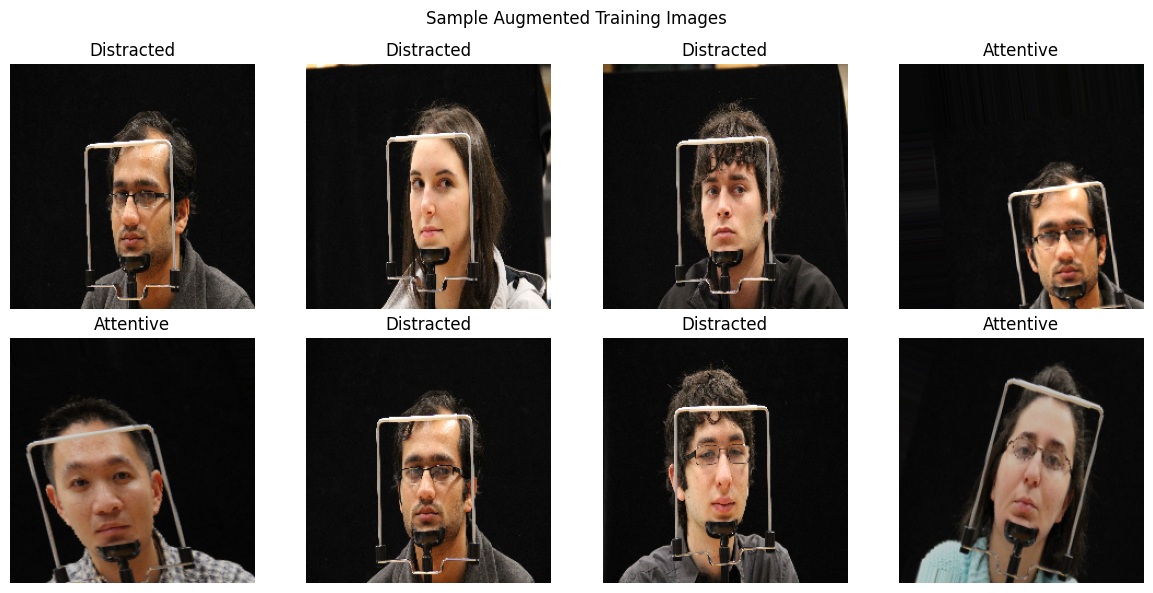

In [ ]:
import matplotlib.pyplot as plt

X_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_batch[i])
    plt.title("Attentive" if y_batch[i]==0 else "Distracted")
    plt.axis("off")
    plt.title("Distracted" if y_batch[i]==1 else "Attentive")
    plt.axis("off")
plt.suptitle("Sample Augmented Training Images")
plt.tight_layout()
plt.show()


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history=model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_data,
    validation_steps=val_data.samples // BATCH_SIZE,
    epochs=10
)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6680 - loss: 1.2387 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 342s 27s/step - accuracy: 0.6752 - loss: 1.2140 - val_accuracy: 0.2769 - val_loss: 4.0319
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 319s 26s/step - accuracy: 0.9679 - loss: 0.1077 - val_accuracy: 0.4062 - val_loss: 1.7134
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 289s 23s/step - accuracy: 0.9861 - loss: 0.0485 - val_accuracy: 0.8767 - val_loss: 0.3813
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 315s 26s/step - accuracy: 0.9927 - loss: 0.0337 - val_accuracy: 0.7509 - val_loss: 0.6229
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 256s 21s/step - accuracy: 0.9977 - loss: 0.0127 - val_accuracy: 0.5773 - val_loss: 1.0069
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 268s 21s/step - accuracy: 0.9993 - loss: 0.0097 - val_accuracy: 0.8602 - val_loss: 0.4216
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 259s 21s/step - accuracy: 0.9955 - loss: 0.0201 - val_accuracy: 0.8889 - val_loss: 0.4439
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 269s 22s/step - accuracy: 0.9975 - loss: 0.0055 - val_accuracy: 0.8594 - val_

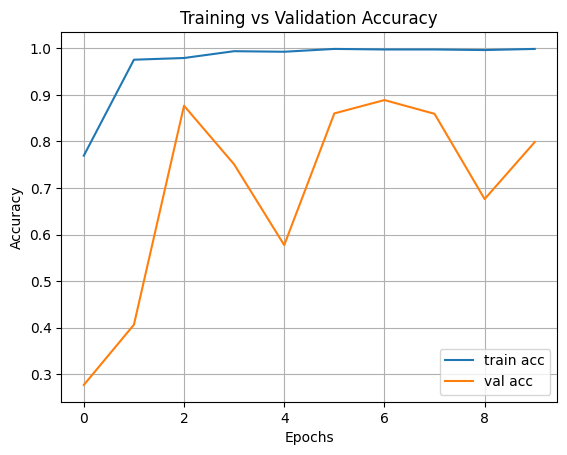

In [57]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step


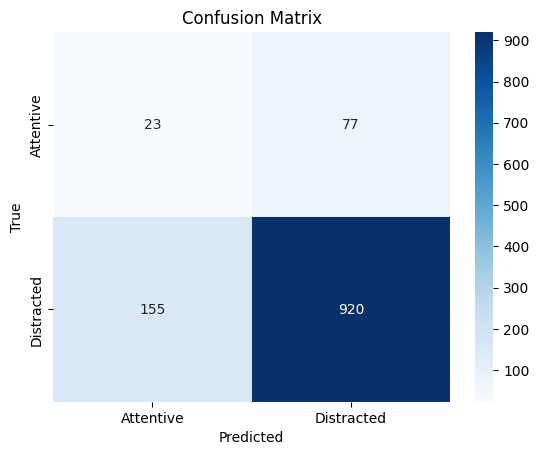

              precision    recall  f1-score   support

   Attentive       0.13      0.23      0.17       100
  Distracted       0.92      0.86      0.89      1075

    accuracy                           0.80      1175
   macro avg       0.53      0.54      0.53      1175
weighted avg       0.86      0.80      0.83      1175



In [58]:
# Predict on validation data
val_data.reset()
y_true = val_data.classes
y_pred = (model.predict(val_data) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Attentive', 'Distracted'], yticklabels=['Attentive', 'Distracted'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=['Attentive', 'Distracted']))


In [96]:
from google.colab import files

uploaded = files.upload()


Saving 0048_2m_0P_0V_0H.jpg to 0048_2m_0P_0V_0H.jpg


In [94]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
def predict_attention(image_path):
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "Attentive" if prediction < 0.5 else "Distracted"
    print(f"🧠 Prediction: {label} ({prediction:.2f})")
    return label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
🧠 Prediction: Attentive (0.44)


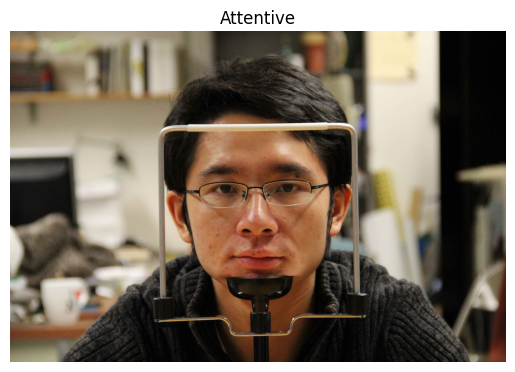

In [87]:
# Replace with actual filename (from uploaded = files.upload())
filename = "0001_2m_0P_0V_0H.jpg"  # e.g., "0001_2m_0P_0V_0H.jpg"
predicted_label = predict_attention(filename)

# Display the image with prediction as title
img = image.load_img(filename)
plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
🧠 Prediction: Distracted (0.82)


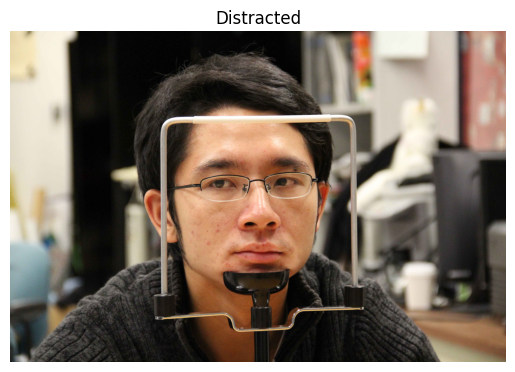

In [88]:
# Replace with actual filename (from uploaded = files.upload())
filename = "0001_2m_15P_0V_-15H.jpg"  # e.g., "0001_2m_0P_0V_0H.jpg"
predicted_label = predict_attention(filename)

# Display the image with prediction as title
img = image.load_img(filename)
plt.imshow(img)
plt.axis('off')
plt.title(predicted_label)
plt.show()
